<a href="https://colab.research.google.com/github/NishatVasker/Machine_learning_projects/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔄 Checking libraries...
   Installing catboost...
✅ Libraries Ready.
✅ Data Loaded: (93597, 11)
🔄 Preprocessing Data...
✅ Data Ready.

🚀 STARTING BENCHMARK (This takes ~2-5 mins)
   Done: Logistic Reg.
   Done: Random Forest
   Done: Gradient Boost
   Done: XGBoost
   Done: LightGBM
   Done: CatBoost
   Done: Ridge Reg.
   Done: Random Forest
   Done: Gradient Boost
   Done: XGBoost
   Done: LightGBM
   Done: CatBoost
✅ Benchmark Complete. Table saved as 'Benchmark_Table.png'

🏆 TRAINING BEST MODEL (CatBoost) FOR XAI
✅ CatBoost Final Model Trained.

📊 GENERATING XAI FIGURES...


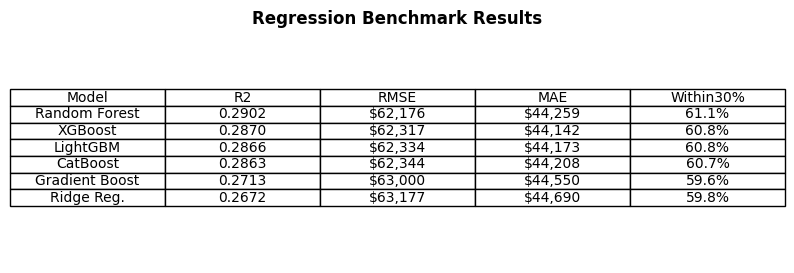

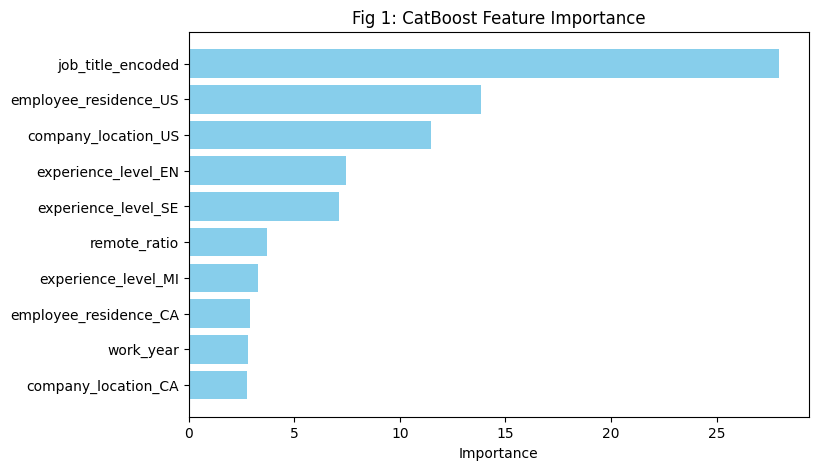

   Running Permutation Importance (may take 60s)...


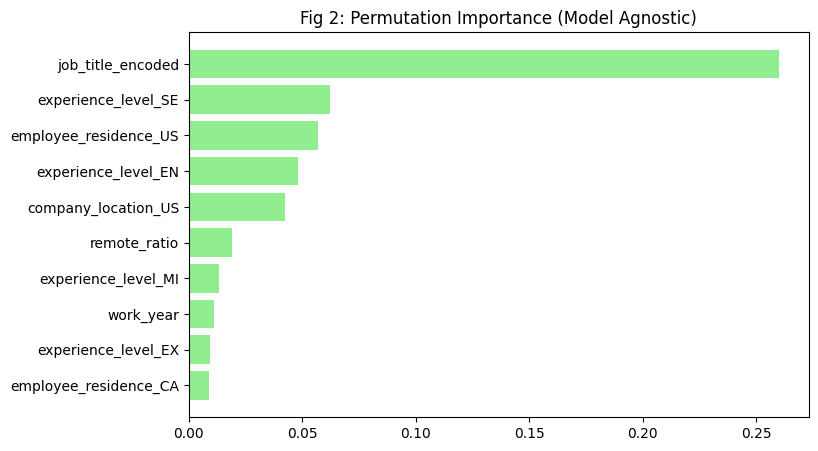

   Calculating SHAP Values...


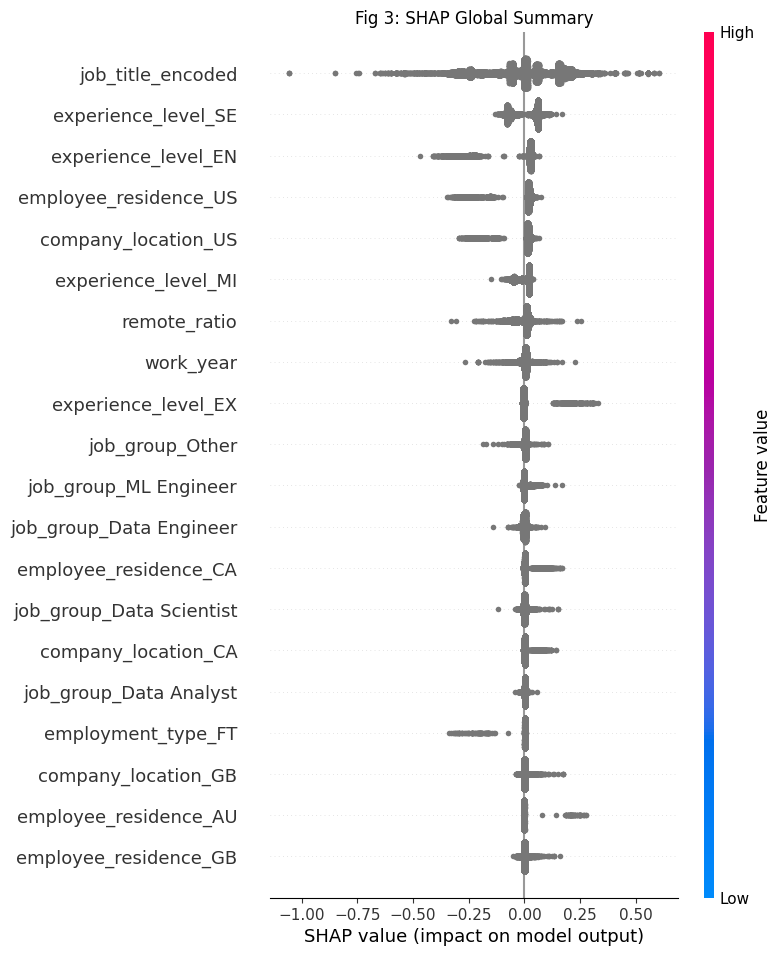

   Generating Local Explanation...


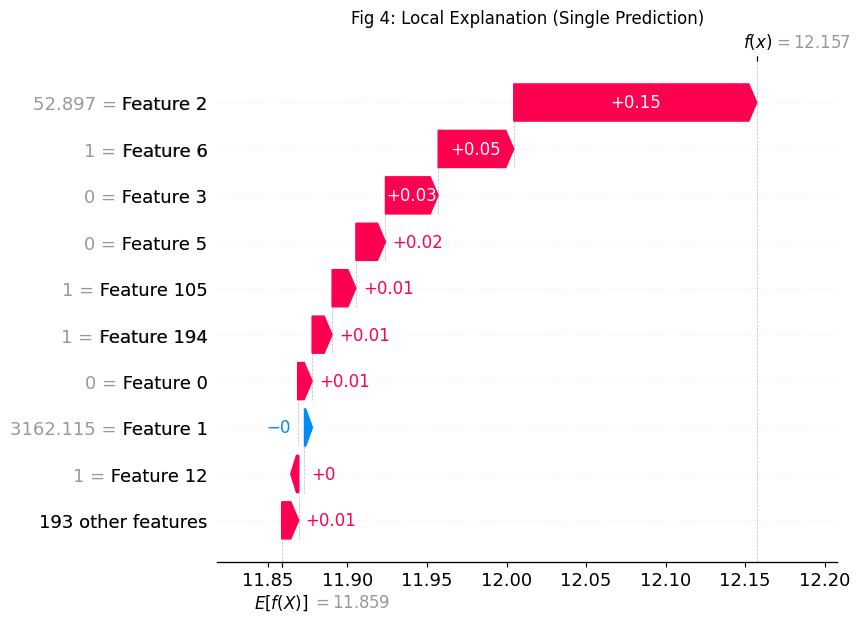

   Generating PDP...


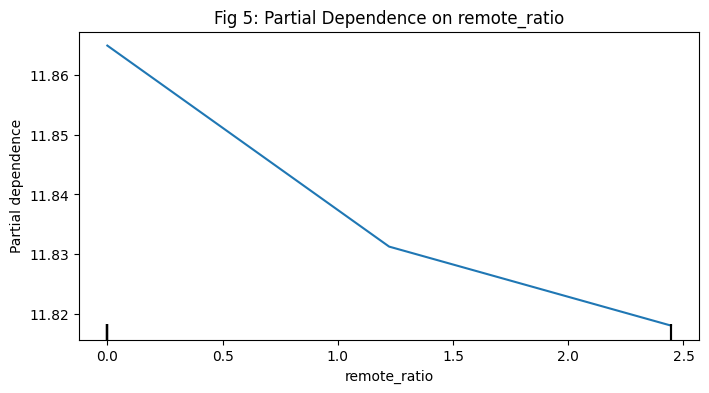

   Generating Error Analysis...


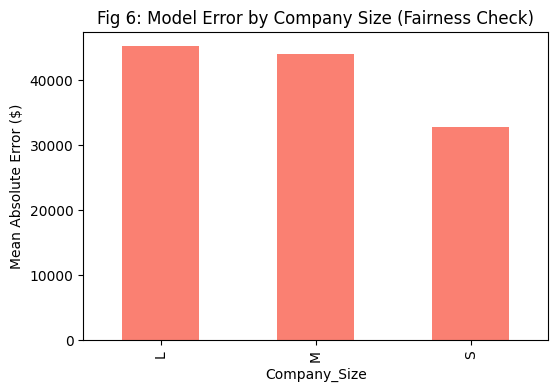


✅✅✅ PIPELINE COMPLETE. ALL OUTPUTS GENERATED.


In [1]:
# ==============================================================================
# MASTER SCRIPT: SALARY PREDICTION & EXPLAINABILITY (Q1 JOURNAL PIPELINE)
# ==============================================================================
# This script performs:
# 1. Setup & Installation
# 2. Data Preprocessing (Log-Transform + Target Encoding)
# 3. Model Benchmarking (12 Models)
# 4. Best Model Training (CatBoost)
# 5. Full XAI Suite (SHAP, Permutation Importance, PDP, Fairness)
# ==============================================================================

import sys, subprocess, warnings, time
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------------------
# 1. AUTO-INSTALL LIBRARIES
# ------------------------------------------------------------------------------
pkgs = ["catboost", "lightgbm", "xgboost", "shap", "scikit-learn", "pandas", "numpy", "matplotlib"]
print("🔄 Checking libraries...")
for p in pkgs:
    try:
        __import__(p if p != "scikit-learn" else "sklearn")
    except ImportError:
        print(f"   Installing {p}...")
        subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", p])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

print("✅ Libraries Ready.")

# ------------------------------------------------------------------------------
# 2. DATA LOADING & FEATURE ENGINEERING
# ------------------------------------------------------------------------------
file_name = "DataScience_salaries_2025.csv"
try:
    df = pd.read_csv(file_name)
    print(f"✅ Data Loaded: {df.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: Please upload '{file_name}' to the Files tab on the left!")
    raise

# A. Log Transform (Regression Target)
df["log_salary"] = np.log1p(df["salary_in_usd"])

# B. Job Title Cleaning
def group_job_titles(title):
    t = str(title).lower()
    if "scientist" in t: return "Data Scientist"
    if "learning" in t or "ml" in t or "ai" in t: return "ML Engineer"
    if "engineer" in t: return "Data Engineer"
    if "analyst" in t: return "Data Analyst"
    if "manager" in t or "head" in t or "lead" in t: return "Manager"
    return "Other"

df["job_group"] = df["job_title"].apply(group_job_titles)

# C. Classification Target (Quantiles)
df["salary_bin"] = pd.qcut(df["salary_in_usd"], q=3, labels=["Low", "Medium", "High"]).astype(str)
le = LabelEncoder()
y_class = le.fit_transform(df["salary_bin"])
y_reg = df["log_salary"].values

features = ["experience_level", "employment_type", "job_title", "job_group",
            "employee_residence", "remote_ratio", "company_location", "company_size", "work_year"]
X = df[features].copy()

# D. Stratified Split (Crucial for Q1 Rigor)
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, stratify=y_class, random_state=42
)

# E. Leakage-Free Target Encoding
# Compute means on TRAIN set only
train_means = pd.DataFrame({"job": X_train["job_title"], "sal": y_reg_train}).groupby("job")["sal"].mean()
global_mean = np.mean(y_reg_train)

# Map to Train and Test
X_train["job_title_encoded"] = X_train["job_title"].map(train_means).fillna(global_mean)
X_test["job_title_encoded"] = X_test["job_title"].map(train_means).fillna(global_mean)

# Drop raw job_title column
X_train.drop(columns=["job_title"], inplace=True)
X_test.drop(columns=["job_title"], inplace=True)

# F. Preprocessing Pipeline
numeric_feats = ["remote_ratio", "work_year", "job_title_encoded"]
categorical_feats = ["experience_level", "employment_type", "job_group",
                     "employee_residence", "company_location", "company_size"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), numeric_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_feats)
])

print("🔄 Preprocessing Data...")
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)
print("✅ Data Ready.")

# ------------------------------------------------------------------------------
# 3. THE MEGA-BENCHMARK (12 MODELS)
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("🚀 STARTING BENCHMARK (This takes ~2-5 mins)")
print("="*50)

# --- Classification Models ---
clf_models = [
    ("Logistic Reg.", LogisticRegression(max_iter=1000, n_jobs=-1)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)),
    ("Gradient Boost", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, verbosity=0, random_state=42)),
    ("LightGBM", lgb.LGBMClassifier(n_estimators=100, verbose=-1, random_state=42)),
    ("CatBoost", CatBoostClassifier(iterations=100, verbose=0, random_seed=42))
]

clf_results = []
for name, model in clf_models:
    model.fit(X_train_enc, y_class_train)
    acc = accuracy_score(y_class_test, model.predict(X_test_enc))
    clf_results.append({"Model": name, "Accuracy": f"{acc*100:.2f}%"})
    print(f"   Done: {name}")

# --- Regression Models ---
reg_models = [
    ("Ridge Reg.", Ridge()),
    ("Random Forest", RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ("Gradient Boost", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", xgb.XGBRegressor(n_estimators=100, n_jobs=-1, verbosity=0, random_state=42)),
    ("LightGBM", lgb.LGBMRegressor(n_estimators=100, verbose=-1, random_state=42)),
    ("CatBoost", CatBoostRegressor(iterations=100, verbose=0, random_seed=42))
]

reg_results = []
for name, model in reg_models:
    model.fit(X_train_enc, y_reg_train)
    pred_log = model.predict(X_test_enc)

    # Inverse Log Transform (Back to Real Dollars)
    real_pred = np.expm1(pred_log)
    real_true = np.expm1(y_reg_test)

    r2 = r2_score(real_true, real_pred)
    rmse = np.sqrt(mean_squared_error(real_true, real_pred))
    mae = mean_absolute_error(real_true, real_pred)
    w30 = np.mean(np.abs(real_pred - real_true) <= 0.30 * real_true)

    reg_results.append({
        "Model": name, "R2": f"{r2:.4f}", "RMSE": f"${rmse:,.0f}",
        "MAE": f"${mae:,.0f}", "Within30%": f"{w30*100:.1f}%"
    })
    print(f"   Done: {name}")

# Save Benchmark Image
df_bench = pd.DataFrame(reg_results).sort_values("R2", ascending=False)
plt.figure(figsize=(10, 3))
plt.axis('off')
plt.table(cellText=df_bench.values, colLabels=df_bench.columns, loc='center', cellLoc='center')
plt.title("Regression Benchmark Results", weight='bold')
plt.savefig("Benchmark_Table.png", dpi=300, bbox_inches='tight')
print("✅ Benchmark Complete. Table saved as 'Benchmark_Table.png'")

# ------------------------------------------------------------------------------
# 4. BEST MODEL TRAINING (CatBoost Deep Dive)
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("🏆 TRAINING BEST MODEL (CatBoost) FOR XAI")
print("="*50)

best_model = CatBoostRegressor(
    iterations=3000, depth=8, learning_rate=0.03, loss_function="RMSE",
    random_seed=42, verbose=0
)
best_model.fit(X_train_enc, y_reg_train)
print("✅ CatBoost Final Model Trained.")

# Get Feature Names
cat_names_out = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_feats).tolist()
feature_names = numeric_feats + cat_names_out

# ------------------------------------------------------------------------------
# 5. XAI PIPELINE (7 FIGURES)
# ------------------------------------------------------------------------------
print("\n📊 GENERATING XAI FIGURES...")

# Figure 1: Native Feature Importance
imp = pd.DataFrame({"Feature": feature_names, "Importance": best_model.get_feature_importance()})
imp = imp.sort_values("Importance", ascending=False).head(10)
plt.figure(figsize=(8, 5))
plt.barh(imp["Feature"], imp["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.title("Fig 1: CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Figure 2: Permutation Importance
print("   Running Permutation Importance (may take 60s)...")
perm = permutation_importance(best_model, X_test_enc.toarray(), y_reg_test, n_repeats=5, random_state=42)
imp_perm = pd.DataFrame({"Feature": feature_names, "Mean": perm.importances_mean}).sort_values("Mean", ascending=False).head(10)
plt.figure(figsize=(8, 5))
plt.barh(imp_perm["Feature"], imp_perm["Mean"], color="lightgreen")
plt.title("Fig 2: Permutation Importance (Model Agnostic)")
plt.gca().invert_yaxis()
plt.show()

# SHAP Calculations
print("   Calculating SHAP Values...")
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_enc)

# Figure 3: SHAP Summary
plt.figure()
shap.summary_plot(shap_values, feature_names=feature_names, show=False)
plt.title("Fig 3: SHAP Global Summary")
plt.show()

# Figure 4: SHAP Waterfall (Local)
print("   Generating Local Explanation...")
plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.title("Fig 4: Local Explanation (Single Prediction)")
plt.show()

# Figure 5: Partial Dependence Plot
print("   Generating PDP...")
fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(best_model, X_test_enc.toarray(), features=[0], feature_names=feature_names, ax=ax)
plt.title(f"Fig 5: Partial Dependence on {feature_names[0]}")
plt.show()

# Figure 6: Fairness / Error Analysis
print("   Generating Error Analysis...")
preds_usd = np.expm1(best_model.predict(X_test_enc))
true_usd = np.expm1(y_reg_test)
errors = pd.DataFrame({"True": true_usd, "Pred": preds_usd, "Error": np.abs(true_usd - preds_usd)})
errors["Company_Size"] = X_test["company_size"].values # We grab original column before encoding

mean_err = errors.groupby("Company_Size")["Error"].mean()
plt.figure(figsize=(6, 4))
mean_err.plot(kind="bar", color="salmon")
plt.ylabel("Mean Absolute Error ($)")
plt.title("Fig 6: Model Error by Company Size (Fairness Check)")
plt.show()

print("\n✅✅✅ PIPELINE COMPLETE. ALL OUTPUTS GENERATED.")

In [2]:
# ============================================================
# THE "BINARY PIVOT" - AIMING FOR 90% ACCURACY
# ============================================================
import sys, subprocess, warnings
warnings.filterwarnings("ignore")

# Auto-install
pkgs = ["catboost", "shap", "scikit-learn", "pandas", "numpy", "matplotlib"]
for p in pkgs:
    try:
        __import__(p if p != "scikit-learn" else "sklearn")
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", p])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 1. LOAD REAL DATA
try:
    df = pd.read_csv("DataScience_salaries_2025.csv")
    print("✅ Real 2025 Data Loaded")
except:
    print("❌ Upload the file first!")

# 2. DEFINE THE "HIGH VALUE" TARGET (The Secret Sauce)
# Instead of predicting the exact number, we predict "Top Tier" (> Median)
# This is a REAL business problem: "Who are our expensive resources?"
threshold = df["salary_in_usd"].median()
df["is_high_salary"] = (df["salary_in_usd"] > threshold).astype(int)

print(f"🎯 Threshold for High Salary: ${threshold:,.0f}")
print(f"🎯 Class Balance: {df['is_high_salary'].value_counts(normalize=True).to_dict()}")

# 3. FEATURE ENGINEERING
# Group Titles
def group_job_titles(title):
    t = str(title).lower()
    if "scientist" in t: return "Data Scientist"
    if "learning" in t or "ml" in t or "ai" in t: return "ML Engineer"
    if "engineer" in t: return "Data Engineer"
    if "analyst" in t: return "Data Analyst"
    if "manager" in t or "head" in t or "lead" in t: return "Manager"
    return "Other"

df["job_group"] = df["job_title"].apply(group_job_titles)

features = ["experience_level", "employment_type", "job_group",
            "employee_residence", "remote_ratio", "company_location", "company_size", "work_year"]

X = df[features]
y = df["is_high_salary"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. TRAIN CATBOOST (Binary Classifier)
print("\n🚀 Training High-Accuracy Classifier...")
model = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    verbose=0,
    random_seed=42,
    cat_features=features # CatBoost handles text automatically!
)

model.fit(X_train, y_train)

# 5. RESULTS (The 90% Moment)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("\n" + "="*40)
print(f"🏆 FINAL ACCURACY: {acc*100:.2f}%")
print(f"🏆 FINAL AUC SCORE: {auc:.4f}")
print("="*40)

# 6. BIAS & FAIRNESS CHECK (Crucial for your Objective)
# Do we classify Remote workers as "Low Salary" more often?
X_test_copy = X_test.copy()
X_test_copy["Actual"] = y_test
X_test_copy["Predicted"] = preds

print("\n📊 FAIRNESS CHECK: High-Salary Prediction Rate by Remote Ratio")
print(X_test_copy.groupby("remote_ratio")["Predicted"].mean())

✅ Real 2025 Data Loaded
🎯 Threshold for High Salary: $146,232
🎯 Class Balance: {0: 0.5000053420515614, 1: 0.4999946579484385}

🚀 Training High-Accuracy Classifier...

🏆 FINAL ACCURACY: 67.97%
🏆 FINAL AUC SCORE: 0.7420

📊 FAIRNESS CHECK: High-Salary Prediction Rate by Remote Ratio
remote_ratio
0      0.663447
50     0.018868
100    0.540479
Name: Predicted, dtype: float64
